In [9]:
import warnings
warnings.filterwarnings("ignore")


### Import Libraries

In [10]:
import pandas as pd
import re
import spacy
import random
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch.nn.utils.rnn import pad_sequence
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import DataLoader, TensorDataset

### Load Dataset

In [11]:
# Load French Monolingual Dataset
sentences = []

with open('/content/news-commentary-v17.fr', 'r', encoding='utf-8') as file:
    for line in file:
        line = line.strip()  # Remove any leading/trailing whitespace
        if line:  # Only add non-empty lines
            sentences.append(line)

# Create a DataFrame with each sentence
french_df = pd.DataFrame(sentences, columns=['Sentence'])
french_df

,Sentence
0,L’or à 10.000 dollars l’once ?
1,SAN FRANCISCO – Il n’a jamais été facile d’avo...
2,"Et aujourd’hui, alors que le cours de l’or a a..."
3,"En décembre dernier, mes collègues économistes..."
4,Mais devinez ce qui s’est passé ?
...,...
243835,BERKELEY – Les ministres des finances et gouve...
243836,La question reste cependant sans réponse de sa...
243837,Without Trump’s bizarre but effective grip on ...
243838,"If so, they richly deserve it."


In [12]:
# Load English Monolingual Dataset
with open('/content/news-commentary-v18.en', 'r', encoding='utf-8') as file:
    sentences = file.readlines()

sentences = [sentence.strip() for sentence in sentences]
english_df = pd.DataFrame(sentences, columns=['Sentence'])
english_df

,Sentence
0,"$10,000 Gold?"
1,SAN FRANCISCO – It has never been easy to have...
2,"Lately, with gold prices up more than 300% ove..."
3,"Just last December, fellow economists Martin F..."
4,Wouldn’t you know it?
...,...
318617,I am under no illusions that this will be easy.
318618,"Politics, not technology, will determine the p..."
318619,It will require a mix of forward-looking polic...
318620,A good model to keep in mind is Denmark’s “fle...


In [13]:
x = 1
french_df = french_df[:x]
english_df = english_df[:x]

### Preprocess Data

In [14]:
NUM_LANGS = 2
MAX_SEQ_LEN = 50

lang_idx_mapping = {
    'english': 0,
    'french': 1,
}

In [15]:
# Remove empty sentences if any
english_df = english_df[english_df['Sentence'].notna() & (english_df['Sentence'] != '')]
french_df = french_df[french_df['Sentence'].notna() & (french_df['Sentence'] != '')]

In [16]:
english_df

,Sentence
0,"$10,000 Gold?"


In [17]:
def preprocess_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub(r'[^\w\s]', '', sentence)  # Remove punctuation
    return sentence

In [18]:
english_df.loc[:, 'Sentence'] = english_df['Sentence'].apply(lambda x: preprocess_text(x))
french_df.loc[:, 'Sentence'] = french_df['Sentence'].apply(lambda x: preprocess_text(x))

In [19]:
def remerge_sent(sent):
    # merges tokens which are not separated by white-space
    # does this recursively until no further changes
    changed = True
    while changed:
        changed = False
        i = 0
        while i < sent.__len__() - 1:
            tok = sent[i]
            if not tok.whitespace_:
                ntok = sent[i + 1]
                # in-place operation.
                with sent.retokenize() as retokenizer:
                    retokenizer.merge(sent[i: i + 2])
                changed = True
            i += 1
    return sent

In [20]:
!python3 -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 74.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [21]:
!python3 -m spacy download fr_core_news_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 MB 12.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [22]:
nlp_en = spacy.load('en_core_web_sm')
nlp_fr = spacy.load('fr_core_news_md')

In [23]:
def tokenize_with_spacy(sentence, nlp):
    doc = nlp(sentence)
    spacy_sentence = remerge_sent(doc)
    return [token.text for token in spacy_sentence]

# Tokenize
english_df['Tokens'] = english_df['Sentence'].apply(lambda x: tokenize_with_spacy(x, nlp_en))
french_df['Tokens'] = french_df['Sentence'].apply(lambda x: tokenize_with_spacy(x, nlp_fr))

In [24]:
# Drop sentences longer than 50 words
english_df = english_df[english_df['Tokens'].apply(len) <= MAX_SEQ_LEN]
french_df = french_df[french_df['Tokens'].apply(len) <= MAX_SEQ_LEN]

### Generate BERT Embeddings

We can use pre trained transformer models for generating embeddings for the tokens, we can use different versions of BERT for generation embeddings for French, German etc.

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [26]:
# Load the pre-trained BERT tokenizer and model
# Load the fast version of the tokenizer

tokenizer_en = AutoTokenizer.from_pretrained('bert-base-uncased', use_fast=True)
bert_model_en = AutoModel.from_pretrained('bert-base-uncased')
bert_model_en = bert_model_en.to(device)
vocab_embeddings_en = bert_model_en.embeddings.word_embeddings.weight  # shape: (vocab_size, 768)

tokenizer_fr = AutoTokenizer.from_pretrained('camembert-base', use_fast=True)
bert_model_fr = AutoModel.from_pretrained('camembert-base')
bert_model_fr = bert_model_fr.to(device)
vocab_embeddings_fr = bert_model_fr.embeddings.word_embeddings.weight  # shape: (vocab_size, 768)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/508 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/811k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

In [27]:
# Retrieves BERT embeddings for a list of tokens using a fast tokenizer, enabling accurate aggregation of subword embeddings into their original token representations.
def get_bert_embeddings(tokens, tokenizer, bert_model):
    inputs = tokenizer(tokens, return_tensors='pt', is_split_into_words=True, padding=False, truncation=True)

    # Get BERT embeddings from the model
    with torch.no_grad():
        outputs = bert_model(**inputs)

    # Get the embeddings for each subword
    token_embeddings = outputs.last_hidden_state.squeeze(0)  # Shape: (sequence_length, hidden_size)
    # Get word_ids to align subword tokens with the original tokens
    word_ids = inputs.word_ids()

    # Aggregate subword embeddings back to their original tokens
    aggregated_embeddings = []
    current_token_embeddings = []

    for idx, word_id in enumerate(word_ids):
        if word_id is None:
            continue
        if len(current_token_embeddings) > 0 and word_id != word_ids[idx - 1]:
            aggregated_embeddings.append(torch.mean(torch.stack(current_token_embeddings), dim=0))
            current_token_embeddings = []
        current_token_embeddings.append(token_embeddings[idx])

    if len(current_token_embeddings) > 0:
        aggregated_embeddings.append(torch.mean(torch.stack(current_token_embeddings), dim=0))

    return torch.stack(aggregated_embeddings)

In [28]:
# Function to generate BERT embeddings for dataFrame
def generate_embeddings(df, tokenizer, bert_model):
    embeddings_list = []
    for _, row in df.iterrows():
        tokenized_sentence = row['Tokens']
        embeddings = get_bert_embeddings(tokenized_sentence, tokenizer, bert_model)
        embeddings_list.append(embeddings)
    return embeddings_list

In [29]:
def generate_padded_embeddings(df, embedding_list, max_len=MAX_SEQ_LEN):
    # Pad the sequences using pad_sequence. It will pad them to the length of the longest sentence.
    padded_embeddings = pad_sequence(embedding_list, batch_first=True, padding_value=0)

    # Truncate the sequences if they are longer than max_len
    if padded_embeddings.size(1) > max_len:
        padded_embeddings = padded_embeddings[:, :max_len, :]
    # If sequences are shorter than max_len, pad them manually
    elif padded_embeddings.size(1) < max_len:
        padding_size = max_len - padded_embeddings.size(1)
        padded_embeddings = F.pad(padded_embeddings, (0, 0, 0, padding_size), value=0)

    # Assign the padded embeddings to the dataframe
    df['Embeddings'] = [padded_embeddings[i] for i in range(padded_embeddings.shape[0])]
    print(f"Padded Embeddings Shape: {padded_embeddings.shape}")

In [30]:
english_embeddings = generate_embeddings(english_df, tokenizer_en, bert_model_en)
english_embeddings[0].shape

torch.Size([2, 768])

In [31]:
generate_padded_embeddings(english_df, english_embeddings)

Padded Embeddings Shape: torch.Size([1, 50, 768])


In [32]:
french_embeddings = generate_embeddings(french_df, tokenizer_fr, bert_model_fr)
french_embeddings[0].shape

torch.Size([5, 768])

In [33]:
generate_padded_embeddings(french_df, french_embeddings)

Padded Embeddings Shape: torch.Size([1, 50, 768])


## Denoising Auto Encoding (DAE)

Noise is added to make sure that self auto encoding mechanism is not just returning the same sequence of words, and rather learns the structure of the sentence, otherwise for a random sequence of words also it will return the same output.

In [34]:
def apply_word_dropout(sentence, pwd=0.1, padding_embedding=None):
    noisy_sentence = []
    drop_count = 0

    for word in sentence:
        if random.random() > pwd:
            noisy_sentence.append(word)
        else:
            drop_count += 1

    if padding_embedding is None:
        padding_embedding = torch.zeros_like(sentence[0])

    noisy_sentence.extend([padding_embedding] * drop_count)
    noisy_sentence_tensor = torch.stack(noisy_sentence)

    return noisy_sentence_tensor

In [35]:
def apply_sentence_shuffling(sentence, k=3, alpha=0.5):
    n = sentence.size(0)

    # Generating random permutation vector q
    q = torch.arange(n).float() + torch.rand(n) * alpha  # Slightly perturb the indices
    _, permuted_indices = torch.sort(q)  # Sorting to get the permutation

    # Apply the shuffle, respecting the condition |σ(i) - i| <= k
    for i in range(n):
        if abs(permuted_indices[i] - i) > k:
            permuted_indices[i] = i

    # Shuffle sentence according to the permuted indices
    shuffled_sentence = sentence[permuted_indices]

    return shuffled_sentence

In [36]:
def apply_noise(x, pwd=0.1, k=3, alpha=0.5):
    if isinstance(x, list):
        x = torch.tensor(x)

    # Apply word dropout
    x_noisy = apply_word_dropout(x, pwd)

    # Apply sentence shuffling
    x_noisy = apply_sentence_shuffling(x_noisy, k, alpha)

    return x_noisy

#### Encoder Decoder With Attention

This is mainly used for longer sentences. As the sentence gets longer, the context vector $(z)$ passed as the first input to the decoder gets diminished or forgotten, and the decoder loses its attention or focus on the main parts of the sequence, causing a drop in the BLEU score.

#### Decoder

The decoder generates the target sentence by iteratively producing each word $y_i$, based on:

$$
p(y_i \mid y_1, \dots, y_{i-1}, x) = g(y_{i-1}, s_i, c_i)
$$

Where:

- $y_i$ is the target word at time step $i$,
- $s_i$ is the hidden state of the decoder LSTM at time step $i$,
- $c_i$ is the context vector that summarizes the relevant information from the encoder.

---

#### Decoder Hidden State Update

The hidden state of the decoder at each time step $i$ is computed by an RNN / LSTM update. The state is conditioned on the previous hidden state $(s_{i-1})$, the previously generated word $(y_{i-1})$, and the context vector $(c_i)$. The context vector contains information from the encoder and helps the decoder focus on the most relevant parts of the source sentence.

$$
s_i = f(s_{i-1}, y_{i-1}, c_i)
$$

Where:
- $s_i$ is the decoder's hidden state at time step $i$,
- $s_{i-1}$ is the hidden state from the previous time step,
- $y_{i-1}$ is the previously generated target word,
- $c_i$ is the context vector at time step $i$.

---

#### Context Vector

The context vector $c_i$ is a weighted sum of the encoder's hidden states (annotations). It reflects the parts of the source sentence that the decoder should focus on when generating the target word $y_i$. Each hidden state $h_j$ from the encoder is weighted by an attention weight $\alpha_{ij}$, which indicates how much attention to pay to that part of the input sentence at time step $i$.

$$
c_i = \sum_{j=1}^{T_x} \alpha_{ij} h_j
$$

Where:
- $h_j$ is the encoder hidden state at position $j$,
- $\alpha_{ij}$ is the attention weight for position $j$ at decoding time step $i$,
- $T_x$ is the length of the input sequence.

---

#### Attention Weights

The attention weight $\alpha_{ij}$ represents how much focus the decoder should place on the $j$-th hidden state of the encoder when generating the $i$-th target word. These attention weights are computed using a softmax function, which ensures that the weights sum to 1 across all positions in the input sequence. This mechanism allows the decoder to pay varying degrees of attention to different parts of the input sequence at each step.

$$
\alpha_{ij} = \frac{\exp(e_{ij})}{\sum_{k=1}^{T_x} \exp(e_{ik})}
$$

Where:
- $e_{ij}$ is the alignment score for the $j$-th input word and the $i$-th target word,
- The denominator sums over all alignment scores for input positions $k$, normalizing the attention weights.

---

#### Alignment Score

The alignment score $e_{ij}$ is computed by a feedforward neural network, known as the **alignment model**. It measures how well the decoder's previous hidden state $s_{i-1}$ aligns with the encoder's hidden state $h_j$. This score helps decide which parts of the source sentence are most relevant when predicting the next target word.

$$
e_{ij} = a(s_{i-1}, h_j)
$$

Where:
- $s_{i-1}$ is the decoder hidden state at time step $i-1$,
- $h_j$ is the encoder hidden state at position $j$,
- $a$ is the alignment model, which can be a simple feedforward network.

### BiLSTM Encoder

Generates sequence of hidden (latent) states for a given sequence of input embeddings (src/tgt language).

In [37]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, lang_embed_dim=32):
        super(Encoder, self).__init__()
        self.lstm = nn.LSTM(input_dim + lang_embed_dim, hidden_dim, bidirectional=True, batch_first=True, num_layers=num_layers)

        # Fully connected layers for final prediction
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, output_dim)

        self.activation = nn.ReLU()  # Activation function
        self.dropout = nn.Dropout(0.5)  # Dropout for regularization
        self.batch_norm = nn.BatchNorm1d(hidden_dim * 2)

        # Language embedding layer
        self.lang_embedding = nn.Embedding(NUM_LANGS, lang_embed_dim)

    def forward(self, inputs, lang_idx):
        # Get language embedding
        lang_emb = self.lang_embedding(lang_idx).unsqueeze(1).expand(-1, inputs.size(1), -1)

        # Concatenate the language embedding with the input embeddings
        inputs_with_lang = torch.cat((inputs, lang_emb), dim=-1)

        lstm_out, _ = self.lstm(inputs_with_lang)  # (batch_size, seq_len, hidden_dim * 2)

        # Apply dropout and batch normalization
        lstm_out = self.dropout(lstm_out)
        lstm_out = self.batch_norm(lstm_out.transpose(1, 2)).transpose(1, 2)

        # Pass through fully connected layers
        fc1_output = self.activation(self.fc1(lstm_out))  # (batch_size, seq_len, hidden_dim)
        fc2_output = self.activation(self.fc2(fc1_output))  # (batch_size, seq_len, hidden_dim // 2)
        latent_output = self.fc3(fc2_output)  # (batch_size, seq_len, output_dim)

        # fc1_output has shape 300*1
        return fc1_output, latent_output

#### LSTM Decoder

Generates sequence of words in a (src/tgt) language based on the previous hidden state of the decoder, the current word (hidden state from the encoder), and a context vector given by a weighted sum over the encoder output states.

In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()

        self.hidden_dim = hidden_dim

        # Attention mechanism to compute attention weights
        # Concatenate hidden state and encoder outputs, and project to hidden_dim
        self.attn = nn.Linear(hidden_dim * 2, hidden_dim)  # Input dim = 2 * hidden_dim, Output = hidden_dim
        self.v = nn.Parameter(torch.rand(hidden_dim))      # Attention vector for scoring

    def forward(self, hidden, encoder_outputs):
        """
        Compute the attention weights and context vector.

        Args:
            hidden: The hidden state of the decoder (batch_size, hidden_dim)
            encoder_outputs: The outputs from the encoder (batch_size, seq_len, hidden_dim)

        Returns:
            context: The context vector (batch_size, hidden_dim)
        """
        batch_size = encoder_outputs.size(0)
        seq_len = encoder_outputs.size(1)
        hidden_dim = encoder_outputs.size(2)

        # Expand hidden state to match the sequence length
        hidden_expanded = hidden.unsqueeze(1).expand(batch_size, seq_len, hidden_dim)  # (batch_size, seq_len, hidden_dim)

        # Concatenate hidden state and encoder outputs along the last dimension
        concatenated = torch.cat((hidden_expanded, encoder_outputs), dim=2)  # (batch_size, seq_len, 2 * hidden_dim)

        # Pass through the attention network
        energy = torch.tanh(self.attn(concatenated))  # (batch_size, seq_len, hidden_dim)

        # Transpose energy to prepare for batch matrix multiplication
        energy = energy.transpose(1, 2)  # (batch_size, hidden_dim, seq_len)

        # Repeat v to match the batch size (for each batch, we use the same attention vector)
        v_expanded = self.v.repeat(batch_size, 1).unsqueeze(1)  # (batch_size, 1, hidden_dim)

        # Compute attention scores using batch matrix multiplication
        attn_weights = torch.bmm(v_expanded, energy).squeeze(1)  # (batch_size, seq_len)

        # Normalize attention weights using softmax
        attn_weights = F.softmax(attn_weights, dim=1)  # (batch_size, seq_len)

        # Compute the context vector as the weighted sum of encoder outputs
        context = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs).squeeze(1)  # (batch_size, hidden_dim)

        return context

In [39]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim, num_layers=3, lang_embed_dim=32):
        super(Decoder, self).__init__()

        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # LSTM layer for decoding
        # Takes input as the context vector of hidden_dim and output from the encoder of latent_dim
        # Outputs a hidden state of hidden_dim
        self.lstm = nn.LSTM(latent_dim + hidden_dim + lang_embed_dim, hidden_dim, num_layers=num_layers, batch_first=True)

        # Attention mechanism
        self.attn = Attention(hidden_dim)

        # Fully connected layer to output the prediction
        self.fc_out = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.5)

        # Language embedding layer
        self.lang_embedding = nn.Embedding(NUM_LANGS, lang_embed_dim)

    def forward(self, latent_vectors, encoder_outputs, hidden, lang_idx):
        """
        Decoder forward pass with attention mechanism.

        Args:
            latent_vectors: The latent vectors from the encoder (batch_size, seq_len, latent_dim), output given by bidirectional LSTM encoder after summarizing (abstracting) the input sentence, that is passing through the fc layers.
            They will be used as input for decoder LSTM, for finding the target word.

            encoder_outputs: The encoder outputs (batch_size, seq_len, latent_dim), output given by bidirectional LSTM encoder of dim 300.
            They will by used for finding the attention weights and context vector.

            hidden: The hidden state from the previous time step (num_layers, batch_size, hidden_dim)

        Returns:
            outputs: The generated output sequence (batch_size, seq_len, output_dim)
            hidden: The updated hidden state (num_layers, batch_size, hidden_dim)
        """
        batch_size = latent_vectors.size(0)
        seq_len = latent_vectors.size(1)

        # Get language embedding
        lang_emb = self.lang_embedding(lang_idx).unsqueeze(1).expand(-1, latent_vectors.size(1), -1)

        # Initialize the output tensor
        outputs = torch.zeros(batch_size, seq_len, self.fc_out.out_features).to(latent_vectors.device)

        # Iterate through the sequence to generate each word
        for t in range(seq_len):
            # Get attention weights and context vector
            # hidden[0][-1] gives the previous hidden state, need to take hidden[0] as hidden is a tuple (h,c)
            context = self.attn(hidden[0][-1], encoder_outputs)

            # Concatenate the context vector, latent vector, and language embedding
            lstm_input = torch.cat((context, latent_vectors[:, t], lang_emb[:, t]), dim=1).unsqueeze(1)

            # Pass through the LSTM
            lstm_out, hidden = self.lstm(lstm_input, hidden)  # lstm_out: (batch_size, 1, hidden_dim)
            lstm_out = self.dropout(lstm_out)

            # Predict the next word
            outputs[:, t] = self.fc_out(lstm_out.squeeze(1))

        return outputs, hidden

    def init_hidden(self, batch_size):
        """ Initialize hidden state and cell state for LSTM """
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(next(self.parameters()).device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(next(self.parameters()).device)
        return (h0, c0)

### Training the DAE Model

In [40]:
# Hyperparameters
BATCH_SIZE = 32
NUM_EPOCHS = 1
NUM_LSTM_LAYERS = 3
LEARNING_RATE = 0.0003
LANG_DIM = 32

# Encoder
ENCODER_INPUT_DIM = 768
ENCODER_HIDDEN_DIM = 300
ENCODER_OUTPUT_DIM = 100

# Decoder
DECODER_OUTPUT_DIM = ENCODER_INPUT_DIM
DECODER_LATENT_DIM = ENCODER_OUTPUT_DIM
DECODER_HIIDEN_DIM = 300

Language index has been added for each sentence, as we are using ```same encoder and decoder``` instance for source and target languages, i.e ```weights are being shared```, so encoder takes in the language index and creates a language embedding which is appended to the input word embedding, also the decoder takes the output generated by encoder, context vector and also the langauge vector to produce output sequence in the given language.

In [41]:
# x and y are same because of auto-encoding
english_dataset = TensorDataset(
    torch.stack(english_df['Embeddings'].tolist()),
    torch.stack(english_df['Embeddings'].tolist()),
    torch.tensor([lang_idx_mapping['english']] * len(english_df))
)
english_loader = DataLoader(
    english_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

french_dataset = TensorDataset(
    torch.stack(french_df['Embeddings'].tolist()),
    torch.stack(french_df['Embeddings'].tolist()),
    torch.tensor([lang_idx_mapping['french']] * len(french_df))
)
french_loader = DataLoader(
    french_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

# Combine both datasets
combined_dataset = torch.utils.data.ConcatDataset([english_dataset, french_dataset])
combined_loader = DataLoader(
    combined_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

In [42]:
# Initialize models
encoder_model = Encoder(
    ENCODER_INPUT_DIM,
    ENCODER_HIDDEN_DIM,
    ENCODER_OUTPUT_DIM,
    NUM_LSTM_LAYERS,
)

decoder_model = Decoder(
    DECODER_LATENT_DIM,
    DECODER_HIIDEN_DIM,
    DECODER_OUTPUT_DIM,
    NUM_LSTM_LAYERS,
)

In [43]:
# Set the models to train mode
encoder_model.train()
decoder_model.train()

Decoder(
  (lstm): LSTM(432, 300, num_layers=3, batch_first=True)
  (attn): Attention(
    (attn): Linear(in_features=600, out_features=300, bias=True)
  )
  (fc_out): Linear(in_features=300, out_features=768, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (lang_embedding): Embedding(2, 32)
)

In [44]:
# Initialize optimizer (Adam)
optimizer = optim.Adam(
    list(encoder_model.parameters()) + list(decoder_model.parameters()),
    lr=LEARNING_RATE,
    betas=(0.5, 0.999),
)

In [45]:
# Loss function (Cosine Loss)
def cosine_similarity_loss(predictions, targets, pad_idx=0):
    # Flatten the predictions and targets
    predictions = predictions.view(-1, predictions.size(-1))  # (batch_size * seq_len, embedding_dim)
    targets = targets.view(-1, targets.size(-1))  # (batch_size * seq_len, embedding_dim)

    # Create a mask to exclude padded positions
    mask = (targets.sum(dim=-1) != pad_idx).float()  # (batch_size * seq_len,)

    # Compute the cosine similarity between the predictions and targets
    cos_sim = F.cosine_similarity(predictions, targets, dim=-1)  # (batch_size * seq_len,)
    loss = (1 - cos_sim) * mask  # Apply mask to exclude padding positions
    loss = loss.sum() / mask.sum()  # Average the loss over non-padding tokens

    return loss

In [46]:
def plot_loss(losses):
    epochs = np.arange(1, len(losses) + 1)
    fig, ax = plt.subplots(figsize=(6, 4))

    norm = plt.Normalize(vmin=min(losses), vmax=max(losses))
    colors = plt.cm.cividis(norm(losses))

    for i in range(len(epochs) - 1):
        alpha_value = max(0.3, 0.8 - i * 0.02)
        ax.plot(epochs[i:i+2], losses[i:i+2], color=colors[i], alpha=alpha_value, linewidth=2)

    ax.fill_between(epochs, losses, color='lightblue', alpha=0.3)

    ax.set_title('Training Loss Over Epochs', fontsize=14, fontweight='bold')
    ax.set_xlabel('Epochs', fontsize=12)
    ax.set_ylabel('Loss', fontsize=12)

    sm = plt.cm.ScalarMappable(cmap='cividis', norm=norm)
    sm.set_array([])
    fig.colorbar(sm, ax=ax, label='Loss Intensity')

    plt.tight_layout()
    plt.show()

In [47]:
# Function for training the model
def train_dae(encoder_model, decoder_model, optimizer, data_loader, clip, pad_idx=0):
    all_losses = []

    for epoch in range(NUM_EPOCHS):
        encoder_model.train()
        decoder_model.train()

        epoch_loss = 0
        for batch in data_loader:
            inputs = batch[0].to(device)  # BERT embeddings
            targets = batch[1].to(device)  # Same because of autoencoding
            lang_idx = batch[2].to(device)  # Get language index for each sentence

            # Add noise to inputs and stack them into a tensor
            noisy_inputs = torch.stack([apply_noise(sentence) for sentence in inputs]).to(device)

            optimizer.zero_grad()

            # Forward pass through encoder
            encoder_outputs, latent_vectors = encoder_model(noisy_inputs, lang_idx)

            # Initialize decoder hidden state for each batch
            hidden = decoder_model.init_hidden(inputs.size(0))

            # Decoder forward pass with attention
            outputs, hidden = decoder_model(latent_vectors, encoder_outputs, hidden, lang_idx)

            # Compute the loss
            loss = cosine_similarity_loss(outputs, targets, pad_idx)

            # Backward pass and optimization
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(encoder_model.parameters(), clip)
            torch.nn.utils.clip_grad_norm_(decoder_model.parameters(), clip)

            # Optimizer step
            optimizer.step()
            epoch_loss += loss.item()

        avg_epoch_loss = epoch_loss / len(data_loader)
        all_losses.append(avg_epoch_loss)

        # Print the loss for each epoch
        print(f'Epoch [{epoch + 1}/{NUM_EPOCHS}], Loss: {avg_epoch_loss:.4f}')

    plot_loss(all_losses)

#### Training DAE

Epoch [1/1], Loss: 0.9962


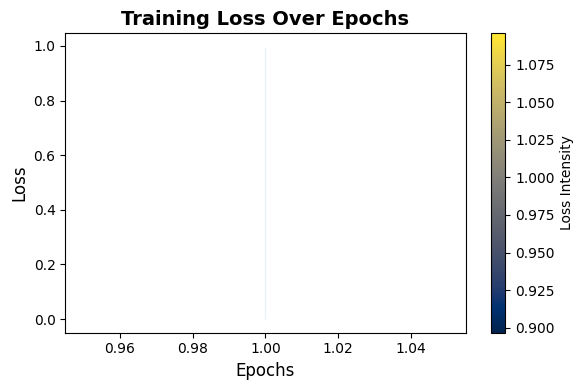

In [48]:
# Train DAE for English Dataset
train_dae(
    encoder_model,
    decoder_model,
    optimizer,
    combined_loader,
    clip=1.0,
)

### Converting Embeddings generated by Decoder to Sentence

In [49]:
def get_closest_token_from_vocab(embedding, vocab_embeddings):
    # Find the closest token from the vocabulary for a given embedding.
    similarities = F.cosine_similarity(embedding, vocab_embeddings, dim=1)
    closest_token_idx = torch.argmax(similarities)
    return closest_token_idx.item()

In [50]:
def embeddings_to_text(output_embeddings, tokenizer, vocab_embeddings):

    batch_size, seq_len, embedding_dim = output_embeddings.size()
    tokens = []

    # Iterate over each sequence in the batch
    for i in range(batch_size):
        sequence_tokens = []

        # Iterate over each embedding in the sequence
        for j in range(seq_len):
            embedding = output_embeddings[i, j]  # Shape: (embedding_dim,)
            token_idx = get_closest_token_from_vocab(embedding, vocab_embeddings)
            token = tokenizer.convert_ids_to_tokens(token_idx)
            sequence_tokens.append(token)

        sentence = tokenizer.convert_tokens_to_string(sequence_tokens)
        tokens.append(sentence)

    return tokens

In [51]:
def generate_text_using_dae(df, tokenizer, vocab_embeddings, lang_idx):
    inputs = torch.stack([sentence for sentence in df['Embeddings']]).to(device)
    lang_idx_tensor = torch.tensor([lang_idx] * len(df)).to(device)

    encoder_outputs, latent_vectors = encoder_model(inputs, lang_idx_tensor)

    # Initialize decoder hidden state for each batch
    hidden = decoder_model.init_hidden(len(df['Embeddings']))

    # Decoder forward pass with attention
    outputs, hidden = decoder_model(latent_vectors, encoder_outputs, hidden, lang_idx_tensor)

    generated_text = embeddings_to_text(outputs, tokenizer, vocab_embeddings)

    def clean_output(text):
        return ' '.join(
            [token for token in text.split() if token not in [
                '[SEP]', '[SEP].', '[MASK]', '[CLS]'
            ]]
        )

    # Clean the generated text
    cleaned_text = [clean_output(sentence) for sentence in generated_text]
    for sentence in cleaned_text:
        print("Generated Sentence:", sentence)

In [52]:
# Generate text for english
generate_text_using_dae(english_df, tokenizer_en, vocab_embeddings_en, lang_idx_mapping['english'])

Generated Sentence: zip rabbi zip zip zip getting zip zip zip zip zip getting zip zip zip zip zip zip zip zip zip zip zip zip zip zip zip zip zip zip zip zip zip zip zip zip zip zip zip getting zip zip getting rabbi zip zip opera zip zip zip


In [53]:
# Generate text for french
generate_text_using_dae(french_df, tokenizer_fr, vocab_embeddings_fr, lang_idx_mapping['french'])

Generated Sentence: Internationale HD Québec HD Québec HD féminines has has Québecspécial anniversaireil HD Québecillo has masculin Québec Internationale HD féminines Québec has has Québec has has has+ HD has has Internationale Québec Internationale has Québec has has Internationale HD An O has Québecillo Internationale has HD


In [54]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

# Discriminator Model
class Discriminator(nn.Module):
    def __init__(self, latent_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.3)
        self.activation = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = self.dropout(self.activation(self.fc1(x)))
        x = self.dropout(self.activation(self.fc2(x)))
        x = torch.sigmoid(self.fc3(x))  # Sigmoid output for binary classification
        return x


In [55]:
encoder_model = Encoder(ENCODER_INPUT_DIM, ENCODER_HIDDEN_DIM, ENCODER_OUTPUT_DIM, NUM_LSTM_LAYERS)
decoder_model = Decoder(DECODER_LATENT_DIM, DECODER_HIIDEN_DIM, DECODER_OUTPUT_DIM, NUM_LSTM_LAYERS)
disc_model = Discriminator(ENCODER_OUTPUT_DIM)

In [56]:
# Optimizers
enc_dec_optimizer = optim.Adam(list(encoder_model.parameters()) + list(decoder_model.parameters()), lr=LEARNING_RATE)
disc_optimizer = optim.Adam(disc_model.parameters(), lr=LEARNING_RATE)


In [57]:
def train_cross_domain_non_parallel(encoder_model, decoder_model, disc_model, enc_dec_optimizer, disc_optimizer,
                                    source_loader, target_loader, clip, lambda_auto=1.0, lambda_cd=1.0, lambda_adv=0.5, pad_idx=0):
    all_losses = []

    for epoch in range(NUM_EPOCHS):
        encoder_model.train()
        decoder_model.train()
        disc_model.train()

        epoch_loss = 0
        for source_batch, target_batch in zip(source_loader, target_loader):
            enc_dec_optimizer.zero_grad()

            # ---------------------------
            # Step 1: DAE for Source Domain (Auto-Encoding Loss)
            # ---------------------------
            source_inputs = source_batch[0].to(device)
            source_lang_idx = source_batch[2].to(device)

            noisy_source_inputs = torch.stack([apply_noise(sentence) for sentence in source_inputs]).to(device)

            source_enc_outputs, source_latents = encoder_model(noisy_source_inputs, source_lang_idx)
            hidden = decoder_model.init_hidden(source_inputs.size(0))
            source_auto_encoded, _ = decoder_model(source_latents, source_enc_outputs, hidden, source_lang_idx)

            # Auto-encoding loss for source
            # cosine_similarity_loss(source_auto_encoded, source_inputs, pad_idx)
            loss_auto_source = cosine_similarity_loss(source_auto_encoded, source_batch[1].to(device), pad_idx)

            # ---------------------------
            # Step 2: DAE for Target Domain (Auto-Encoding Loss)
            # ---------------------------
            target_inputs = target_batch[0].to(device)
            target_lang_idx = target_batch[2].to(device)

            noisy_target_inputs = torch.stack([apply_noise(sentence) for sentence in target_inputs]).to(device)

            target_enc_outputs, target_latents = encoder_model(noisy_target_inputs, target_lang_idx)
            hidden = decoder_model.init_hidden(target_inputs.size(0))
            target_auto_encoded, _ = decoder_model(target_latents, target_enc_outputs, hidden, target_lang_idx)

            # Auto-encoding loss for target
            # cosine_similarity_loss(target_auto_encoded, target_inputs, pad_idx)
            loss_auto_target = cosine_similarity_loss(target_auto_encoded, target_batch[1].to(device), pad_idx)

            # ---------------------------
            # Step 3: Cross-Domain Translation (Source -> Target, without parallel requirement)
            # ---------------------------
            # Translate source to target (without needing target data to be a direct translation)
            hidden = decoder_model.init_hidden(source_inputs.size(0))
            translated_to_target, _ = decoder_model(source_latents, source_enc_outputs, hidden, lang_idx=target_lang_idx)

            # Re-encode the translated target sentence to enforce shared latent space structure
            target_re_enc_outputs, target_re_latents = encoder_model(translated_to_target, target_lang_idx)
            hidden = decoder_model.init_hidden(target_inputs.size(0))
            translated_back_to_source, _ = decoder_model(target_re_latents, target_re_enc_outputs, hidden, lang_idx=source_lang_idx)

            # Cross-domain reconstruction loss
            # cosine_similarity_loss(translated_back_to_source, source_inputs, pad_idx)
            loss_cd = cosine_similarity_loss(translated_back_to_source, source_batch[1].to(device), pad_idx)

            # ---------------------------
            # Step 4: Adversarial Loss for Shared Latent Space
            # ---------------------------
            disc_optimizer.zero_grad()

            # Train discriminator to differentiate source and target latent vectors
            source_latents = encoder_model(source_inputs, source_lang_idx)[1]
            target_latents = encoder_model(target_inputs, target_lang_idx)[1]

            disc_loss_src = F.binary_cross_entropy_with_logits(disc_model(source_latents), torch.ones(source_latents.size(0), 50, 1).to(device))
            disc_loss_tgt = F.binary_cross_entropy_with_logits(disc_model(target_latents), torch.zeros(target_latents.size(0),50, 1).to(device))
            disc_loss = disc_loss_src + disc_loss_tgt

            # Update discriminator
            disc_loss.backward(retain_graph=True)
            disc_optimizer.step()

            # Adversarial loss for encoder to fool the discriminator
            adv_loss_gen = F.binary_cross_entropy_with_logits(disc_model(source_latents), torch.zeros(source_latents.size(0),50, 1).to(device))

            # ---------------------------
            # Step 5: Combine Losses and Update Encoder-Decoder
            # ---------------------------
            total_loss = (
                lambda_auto * (loss_auto_source + loss_auto_target) +
                lambda_cd * loss_cd +
                lambda_adv * adv_loss_gen
            )
            print(1)
            total_loss.backward(retain_graph=True)

            # Clip gradients and update encoder-decoder
            torch.nn.utils.clip_grad_norm_(encoder_model.parameters(), clip)
            torch.nn.utils.clip_grad_norm_(decoder_model.parameters(), clip)
            enc_dec_optimizer.step()

            # Accumulate loss
            epoch_loss += total_loss.item()

        avg_epoch_loss = epoch_loss / len(source_loader)
        all_losses.append(avg_epoch_loss)
        print(f'Epoch [{epoch + 1}/{NUM_EPOCHS}], Auto Loss (Source): {loss_auto_source.item():.4f}, '
              f'Auto Loss (Target): {loss_auto_target.item():.4f}, Cross-Domain Loss: {loss_cd.item():.4f}, '
              f'Adv Loss: {disc_loss.item():.4f}, Total Loss: {avg_epoch_loss:.4f}')

    plot_loss(all_losses)


1
Epoch [1/1], Auto Loss (Source): 1.0003, Auto Loss (Target): 1.0355, Cross-Domain Loss: 0.9944, Adv Loss: 1.4441, Total Loss: 3.5117


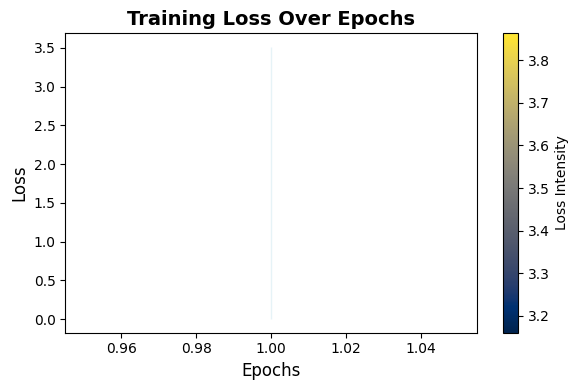

In [58]:
train_cross_domain_non_parallel(
    encoder_model,
    decoder_model,
    disc_model,
    enc_dec_optimizer,
    disc_optimizer,
    english_loader,
    french_loader,
    clip=1.0
)

In [59]:
def generate_cross_domain_text(df, encoder_model, decoder_model, tokenizer, vocab_embeddings, source_lang_idx, target_lang_idx):
    """
    Generate cross-domain sentences by encoding source sentences and decoding in the target domain.

    Args:
        df (DataFrame): DataFrame containing source sentences and their embeddings.
        encoder_model (nn.Module): Encoder model.
        decoder_model (nn.Module): Decoder model.
        tokenizer: Tokenizer for converting tokens to text.
        vocab_embeddings: Vocabulary embeddings for decoding.
        source_lang_idx (int): Language index for the source language.
        target_lang_idx (int): Language index for the target language.

    Returns:
        list of str: Generated sentences in the target language.
    """
    # Stack embeddings from DataFrame and set to device
    inputs = torch.stack([sentence for sentence in df['Embeddings']]).to(device)
    source_lang_tensor = torch.tensor([source_lang_idx] * len(df)).to(device)

    # Step 1: Encode input sentences in the source language
    encoder_outputs, latent_vectors = encoder_model(inputs, source_lang_tensor)

    # Initialize decoder hidden state for each batch in target language
    hidden = decoder_model.init_hidden(len(df['Embeddings']))
    target_lang_tensor = torch.tensor([target_lang_idx] * len(df)).to(device)

    # Step 2: Decode latent vectors in the target language
    outputs, hidden = decoder_model(latent_vectors, encoder_outputs, hidden, target_lang_tensor)

    # Step 3: Convert output embeddings to text using vocabulary embeddings
    generated_text = embeddings_to_text(outputs, tokenizer, vocab_embeddings)

    # Clean up special tokens from generated sentences
    def clean_output(text):
        return ' '.join(
            [token for token in text.split() if token not in [
                '[SEP]', '[SEP].', '[MASK]', '[CLS]'
            ]]
        )

    cleaned_text = [clean_output(sentence) for sentence in generated_text]

    # Print and return generated cross-domain sentences
    for sentence in cleaned_text:
        print("Generated Target Sentence:", sentence)

    return cleaned_text


In [60]:
def get_closest_token_from_vocab(embedding, vocab_embeddings):
    similarities = F.cosine_similarity(embedding.unsqueeze(0), vocab_embeddings, dim=1)
    closest_token_idx = torch.argmax(similarities)
    return closest_token_idx.item()


In [61]:
def embeddings_to_text(output_embeddings, tokenizer, vocab_embeddings):
    """
    Convert output embeddings to readable text by finding closest tokens from the vocabulary.

    Args:
        output_embeddings (torch.Tensor): Output embeddings from the decoder.
        tokenizer: Tokenizer with vocab to convert token indices to words.
        vocab_embeddings (torch.Tensor): Embeddings for the vocabulary.

    Returns:
        list of str: List of sentences as strings.
    """
    batch_size, seq_len, embedding_dim = output_embeddings.size()
    tokens = []

    # Iterate over each sequence in the batch
    for i in range(batch_size):
        sequence_tokens = []

        # Iterate over each embedding in the sequence
        for j in range(seq_len):
            embedding = output_embeddings[i, j]  # Shape: (embedding_dim,)
            token_idx = get_closest_token_from_vocab(embedding, vocab_embeddings)
            token = tokenizer.convert_ids_to_tokens(token_idx)
            sequence_tokens.append(token)

        # Convert tokens to a sentence
        sentence = tokenizer.convert_tokens_to_string(sequence_tokens)
        tokens.append(sentence)

    return tokens


In [62]:
# Example DataFrame with source domain embeddings
source_df = english_df  # Replace `source_embeddings` with your data

# Source and target language indices
source_lang_idx = lang_idx_mapping['english']  # e.g., 0 for English
target_lang_idx = lang_idx_mapping['french']   # e.g., 1 for French

# Generate cross-domain sentences from English to French
generate_cross_domain_text(
    source_df,
    encoder_model,
    decoder_model,
    tokenizer_fr,
    vocab_embeddings_fr,
    source_lang_idx,
    target_lang_idx
)


Generated Target Sentence: vie vie Seconde autre Seconde vie lieu vie vie autre lieu vie seconde vie vie vieautre seconde existence existence vie seconde vie vie vie vie vie vie lieu vie viens vieautre vie vie lieu invention autre lieu levée autre vie lieu autre vie lieu Lucas vie vie vie


['vie vie Seconde autre Seconde vie lieu vie vie autre lieu vie seconde vie vie vieautre seconde existence existence vie seconde vie vie vie vie vie vie lieu vie viens vieautre vie vie lieu invention autre lieu levée autre vie lieu autre vie lieu Lucas vie vie vie']

In [63]:
english_df

,Sentence,Tokens,Embeddings
0,10000 gold,"[10000, gold]","[[tensor(0.1158), tensor(0.5598), tensor(-0.16..."
